## 과제 목표

1. PyTorch를 이용한 딥러닝 모델 구축 및 학습 방법 이해
2. Fully connected network와 CNN 모델의 이해
3. 이미지 분류기 구축 및 학습

# 환경 세팅

본 실습에서 사용할 라이브러리를 import 하겠습니다.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

딥러닝 모델은 매우 큰 행렬 연산을 빠르게 수행해야 합니다. 때문에 CPU만으로는 연산이 느리거나 불가능한 경우가 많습니다. 따라서 GPU를 주로 사용합니다. 아래 `set_device` 함수는 디바이스를 설정합니다.

> 🪄 Colab에서 GPU를 사용하려면 우측 상단의 '추가 연결 옵션'(RAM, 디스크 statistic 옆 화살표 버튼)에서 [런타임 유형 변경] - [하드웨어 가속기] 에서 GPU로 옵션을 변경해주세요.

In [2]:
def set_device(use_gpu):
    """Set the device to run the code.

    Choose CUDA (GPU) if you want to use & it is available,
    if not, choose CPU.

    Args:
        use_gpu (bool): whether you want to use GPU
    Returns:
        Torch.device: device to use in the code
    """
    if use_gpu and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using Device: {device}")
    return device

# Test the function
device = set_device(use_gpu="True")
print(f"Device: {device}")

Using Device: cuda
Device: cuda


아래는 본 실습에 사용할 설정 값입니다.

In [3]:
class Config:
    def __init__(
        self,
        use_gpu=True,
        lr=1e-2,
        epoch=5,
        log_interval=100,
        dataset_path='./datasets',
        image_size=32,
        num_train_data=49000,
        batch_size=64,
        mlp_hidden_dim=512,
        cnn_in_channel=3,
        cnn_channel1=12,
        cnn_channel2=8,
    ):
        # 모델 학습 관련 설정
        self.use_gpu = use_gpu # GPU 사용 여부
        self.lr = lr # learning rate
        self.epoch = epoch # epoch 수
        self.log_interval = log_interval # 실행 상황을 출력할 빈도

        # 데이터셋 설정
        self.dataset_path = dataset_path # 데이터셋을 다운받을 위치
        self.classes = ( # 클래스 종류
            'plane', 'car', 'bird', 'cat','deer',
            'dog', 'frog', 'horse', 'ship', 'truck',
        )
        self.num_classes = len(self.classes) # 클래스 개수로
        self.image_size = image_size # 이미지의 가로/세로 크기

        # 데이터 로더 설정
        self.num_train_data = num_train_data # training set으로 사용할 이미지 개수
        self.batch_size = batch_size # 한 배치 당 이미지 개수. GPU 성능이 낮을 경우 더 낮게 설정. 보통 2의 제곱수.

        # FCN 사용 시 설정
        self.mlp_input_size = self.image_size * self.image_size * 3 # MLP 입력 크기
        self.mlp_hidden_dim = mlp_hidden_dim # MLP hidden layers의 데이터 차원

        # CNN 사용 시 설정
        self.cnn_in_channel = cnn_in_channel # CNN 입력 채널 수
        self.cnn_channel1 = cnn_channel1 # CNN 은닉층1 채널 수
        self.cnn_channel2 = cnn_channel2 # CNN 은닉층2 채널 수

        # 실행 디바이스 설정
        self.device = set_device(self.use_gpu)

        # 데이터셋 다운로드 폴더 생성
        if not os.path.exists(self.dataset_path):
            os.makedirs(self.dataset_path, exist_ok=True)

# Basic Neural Network 구현하기

## 1. 데이터셋 내 데이터를 시각화하는 함수 구현

0~255 사이의 픽셀값을 가지는 이미지 데이터를 모델이 처리할 수 있도록 텐서로 변경하고 [-1, 1] 범위로 픽셀 값을 정규화하는 data transformation을 정의합니다.

In [4]:
def get_transform():
    transform = T.Compose([
        T.ToTensor(), # 텐서화
        T.Normalize(  # 정규화 (각 채널의 mean과 std를 지정)
            mean = (0.5, 0.5, 0.5),
            std  = (0.5, 0.5, 0.5),
        ),
    ])
    return transform

CIFAR10 데이터셋을 다운받아 가져오고, 데이터로더를 선언해 데이터를 가져오는 방식을 지정합니다.

In [5]:
def make_dataloader(dataset_path, batch_size, transform):
    # Dataset split
    cifar10_train = torchvision.datasets.CIFAR10(
        dataset_path, train=True, download=True, transform=transform,
    )

    cifar10_val = torchvision.datasets.CIFAR10(
        dataset_path, train=True, download=True, transform=transform,
    )

    cifar10_test = torchvision.datasets.CIFAR10(
        dataset_path, train=False, download=True, transform=transform,
    )

    # Dataloader
    loader_train = DataLoader(
        dataset    = cifar10_train,
        batch_size = batch_size,
        shuffle    = True, # 데이터셋 내 데이터를 가져오는 순서를 섞음
        drop_last  = True, # 맨 마지막 배치가 배치 크기에 맞지 않을 경우 버림
    )

    loader_val = DataLoader(
        dataset    = cifar10_val,
        batch_size = batch_size,
        shuffle    = True,
    )

    loader_test = DataLoader(
        dataset    = cifar10_test,
        batch_size = batch_size,
        shuffle    = False,
    )

    return loader_train, loader_val, loader_test

가져온 데이터셋 내 데이터가 어떻게 생겼는지 보기 위하여, 시각화 함수를 만들어보겠습니다.

앞서 이미지를 텐서로 만들고 정규화하는 transformation을 거쳤는데, 시각화를 위해서는 이를 다시 되돌려야합니다. 또한 화면에 띄우는 작업도 필요합니다. 이 과정을 수행하는 함수 `visualize()`를 구현합니다.

In [6]:
############################################################################
# Req 2-1: 데이터셋 내 데이터를 시각화하는 함수 구현                       #
############################################################################
def visualize(img):
    """
    Args:
        img (torch.Tensor): A image to visualize, shape: [C, H, W]
    """
    ###################################################################################
    # TODO: 데이터로더가 가져온 데이터셋 내 이미지(`img`)를 입력 받아 transform되었던 #
    # 형태를 다시 되돌리고, 이를 화면에 출력한다.                                     #
    ###################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) [-1, -1] 범위로 normalize된 데이터를 [0,1] 범위로 unnormalize
    # 2) Tensor형인 이미지를 numpy 배열로 변환
    # 3) [Channel, Hight, Width] 순서의 축을 [Hight, Width, Channel] 순서로 변경
    # 4) matplotlib의 plt.imshow() 함수로 시각화

    # 1) [-1, -1] 범위로 normalize된 데이터를 [0,1] 범위로 unnormalize
    img = (img + 1) / 2  # Normalize를 원래대로 되돌리기

    # 2) Tensor형인 이미지를 numpy 배열로 변환
    # img.numpy(): CPU에 있는 텐서에만 사용 가능
    img = img.detach().cpu().numpy()  # Tensor를 numpy로 변환

    # 3) [Channel, Height, Width] 순서의 축을 [Height, Width, Channel] 순서로 변경
    img = np.transpose(img, (1, 2, 0))  # 차원 변경

    # 4) matplotlib의 plt.imshow() 함수로 시각화
    plt.imshow(img)
    plt.axis('off')  # 축 숨기기
    plt.show()  # 이미지 표시

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

아래 코드로 데이터셋 및 데이터로더를 불러오고, `visualize()` 함수를 테스트해볼 수 있습니다.

Using Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


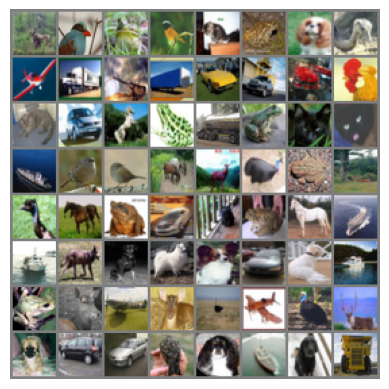

In [ ]:
# 실행 디바이스 및 configuration 설정
config = Config()

# 이미지 데이터의 transform 정의하기
transform = get_transform()

# 데이터로더 불러오기
train_loader, val_loader, test_loader = make_dataloader(
    dataset_path=config.dataset_path,
    batch_size=config.batch_size,
    transform=transform,
)

# 데이터셋의 하나를 뽑아 시각화 함수 사용해보기
images, labels = next(iter(train_loader))
visualize(torchvision.utils.make_grid(images))

## 2. Model 구성하기

아래 구조로 TwoLayerFC 모델과, 해당 모델의 forward 연산을 정의하겠습니다.

- Linear Layer: 이미지를 flatten 할 레이어
- Fully Connected Layer 모듈
    - FC1: input data -> hidden feature
    - ReLU
    - FC2: hidden feature -> output (각 클래스 별 classification 점수)

`nn.Module` 을 상속받은 `TwoLayerFC` 모델의 `__init__` 함수에 모델 레이어를, `forward` 함수에 forward 연산을 정의하면 됩니다.

In [ ]:
############################################################################
# Req 2-2: TwoLayerFC 모델 구성하기                                        #
############################################################################

class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_dim, num_class):
        """
        Define model layers and initialize model weights

        Args:
            input_size  (int): dimension of input data
            hidden_dim (int): dimension of hidden state
            num_class (int): the number of data classes
        """
        super().__init__()

        ################################################################################
        # TODO: 조건에 맞게 모델의 레이어를 정의함                                     #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 1) 이미지를 flatten 할 Linear layer 정의
        # 2) 두 개의 FC layer와 그 사이를 잇는 ReLU 활성화함수를 nn.Sequential로 묶어서 하나의 모듈로 정의
        #    - 첫 번째 FC: input data -> hidden feature
        #    - ReLU activation function
        #    - 두 번째 FC: hidden feature -> output (각 클래스 별 classification 점수)

        # 1) 이미지를 flatten할 레이어 정의
        self.flatten = nn.Flatten()
        # 2) 두 fully connected layer 정의 & Sequential로 묶기
        self.linear_block = nn.Sequential(
            nn.Linear(input_size, hidden_dim),  # 첫 번째 FC: input data -> hidden feature
            nn.ReLU(),                           # ReLU 활성화 함수
            nn.Linear(hidden_dim, num_class)    # 두 번째 FC: hidden feature -> output
        )

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

    def forward(self, x):
        """
        Define the forward pass of network

        Args:
            x (torch.Tensor): Input data (shape - [B, C, H, W])
        Returns:
            torch.Tensor:
                Results of forward pass which are classification scores
                of each data for each class. (shape - [B, num_class])
        """
        ###########################################################################################
        # TODO: __init__에서 정의한 레이어 및 모듈을 활용하여 이미지가 각 클래스 별 점수로 나오는 #
        # 연산을 수행함                                                                           #
        ###########################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 1) 이미지를 flatten하기
        # 2) FC, ReLU, FC를 거쳐 최종 출력(각 클래스 별 classification 점수)인 리턴값을 구하기

        # 1) 이미지를 flatten하기
        x = self.flatten(x)
        # 2) FC, ReLU, FC를 거쳐 최종 출력(각 클래스 별 classification 점수)인 리턴값을 구하기
        x = self.linear_block(x)  # 정의된 모듈을 통해 점수 계산

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return x


모델을 선언하고 레이어의 구성, 모델의 파라미터를 확인하는 방법은 아래와 같습니다.

In [ ]:
# 모델을 선언하기
model = TwoLayerFC(
    input_size = config.mlp_input_size,
    hidden_dim = config.mlp_hidden_dim,
    num_class  = config.num_classes,
)

# 모델의 레이어 구성 확인하기
print(model)

# 모델의 파라미터 확인하기
for name, param in model.named_parameters():
    print(f"Layer: {name}\nSize: {param.size()}\nValues : {param[:2]} \n")

TwoLayerFC(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_block): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Layer: linear_block.0.weight
Size: torch.Size([512, 3072])
Values : tensor([[-0.0044,  0.0063, -0.0171,  ..., -0.0111, -0.0047,  0.0063],
        [ 0.0115, -0.0147, -0.0059,  ..., -0.0162, -0.0052,  0.0017]],
       grad_fn=<SliceBackward0>) 

Layer: linear_block.0.bias
Size: torch.Size([512])
Values : tensor([-0.0090,  0.0167], grad_fn=<SliceBackward0>) 

Layer: linear_block.2.weight
Size: torch.Size([10, 512])
Values : tensor([[-0.0112,  0.0332, -0.0049,  ..., -0.0407,  0.0142, -0.0085],
        [ 0.0423, -0.0187, -0.0212,  ...,  0.0230, -0.0152, -0.0051]],
       grad_fn=<SliceBackward0>) 

Layer: linear_block.2.bias
Size: torch.Size([10])
Values : tensor([ 0.0392, -0.0421], grad_fn=<SliceBackward0>) 



## 3. 모델 학습과정 구현하기

모델을 학습하는 `train()` 함수를 구현해봅시다. 모델의 가중치가 업데이트되는 학습 과정은 아래와 같이 이루어집니다.

- Optimizer 초기화: 우리가 조정(학습)하려는 모델의 파라미터를 전달합니다.
- 학습 loop 내에서
    - `optimizer.zero_grad()`으로 모델 파라미터의 그래디언트를 리셋합니다.
    - model output 및 loss 계산
    - `loss.backward()`로 backpropagation합니다. PyTorch에서 자동적으로 각 파라미터에 대해 그래디언트를 계산해 저장합니다.
    - `optimizer.step()`으로 위에서 계산한 그래디언트를 이용해 파라미터를 업데이트합니다.

`train()` 함수에서는 학습 loop 내의 내용을 구현합니다.

In [7]:
############################################################################
# Req 2-3: 모델을 학습시키는 train() 함수 구현하기                         #
############################################################################


def train(model, train_loader, optimizer, device, log_interval=50):
    model.train() # 모델을 train 모드로 설정합니다.

    for step, data in enumerate(train_loader): # 각 데이터 배치로 각 step을 학습
        ############################################################################################
        # TODO: 데이터 배치 하나를 처리하는 train 프로세스를 구현함. Optimizer에서 gradient를      #
        # 초기화하고, 데이터를 불러오며, 모델의 예측값을 얻고, 정답 값과 차이를 구해 loss로 삼음.  #
        # loss를 backpropagation하고 네트워크의 가중치를 업데이트함.                               #
        ############################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 1) Optimizer `optimizer`의 gradient 값을 초기화
        # 2) 배치 내 데이터를 불러오고 `device`로 데이터가 올라갈 디바이스를 지정함
        # 3) Forward pass를 통해 모델의 출력(예측값)을 생성함
        # 4) cross entropy loss를 계산함
        # 5) Loss를 backpropagation하여 gradient를 전달함
        # 6) optimizer로 네트워크 가중치를 업데이트함
        # 7) [Optional] 로깅 용으로 loss를 출력함

        # 1) Optimizer `optimizer`의 gradient 값을 초기화
        optimizer.zero_grad()

        # 2) 배치 내 데이터를 불러오고 `device`로 데이터가 올라갈 디바이스를 지정함
        inputs, targets = data  # 데이터에서 입력과 정답을 분리
        inputs, targets = inputs.to(device), targets.to(device)  # device로 이동

        # 3) Forward pass를 통해 모델의 출력(예측값)을 생성함
        outputs = model(inputs)

        # 4) cross entropy loss를 계산함
        loss = F.cross_entropy(outputs, targets)

        # 5) Loss를 backpropagation하여 gradient를 전달함
        loss.backward()

        # 6) optimizer로 네트워크 가중치를 업데이트함
        optimizer.step()

        # [Optional] 로깅 용으로 loss를 출력함
        if step % log_interval == 0:
            print(f"Step {step} / {len(train_loader)-1} | Loss {loss.item():.4f}")

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

## 4. 모델 테스트 과정 구현하기

학습한 모델의 정확도(성능)을 측정하는 `test()` 함수를 구현합니다. `train()`과 유사하지만 크게는 아래 두 요소가 다릅니다.

- 모델의 모드 변경: train이 아닌 eval 모드
- Gradient 계산/저장 안 함: `torch.no_grad()`나 `@torch.no_grad()`를 통해 그래디언트 계산을 막습니다. Test에선 불필요하기 때문입니다.
- 성능 측정: accuracy (=맞은 개수/전체 개수)를 계산하여 모델의 성능을 측정합니다.

In [8]:
############################################################################
# Req 2-4: 모델을 평가하는 test() 함수 구현하기                                #
############################################################################

def test(model, dataloader, device, mode="val"):
    ################################################################################
    # TODO: 실제 클래스를 모델의 예측이 얼마나 잘 맞추었는지 accuracy를 측정함             #
    # 전체 validation/test set을 돌면서 맞춘 개수를 누적해서 더하고, 전체 개수로 나누어     #
    # accuracy를 측정할 수 있음. 한 배치에 대한 처리 과정을 구현함.                       #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) 배치 내 데이터를 불러오고 `device`로 데이터가 올라갈 디바이스를 지정함
    # 2) Forward pass를 통해 모델의 출력(예측값)을 생성함
    # 3) `mode`가 validation(`val`)일 때는 loss 값을 계산함
    # 4) 예측한 클래스를 추출함(top-1). 예측값이 각 클래스의 점수이므로, 값이 최대인 클래스를 찾음
    # 5) 정답을 맞춘 개수를 누적합함
    # 6) Accurcy를 계산함

    cnt_correct = 0 # 전체 셋 중 정답을 맞춘 개수
    tot_num = len(dataloader.dataset) # 전체 개수
    tot_loss = 0 # loss 총합

    model.eval() # 모델을 eval 모드로 전환. Batch Normalization을 수행하지 않는 등 필요 없는 작업을 자동으로 끔.

    with torch.no_grad(): # gradient 계산을 하지 않음.
        for step, data in enumerate(dataloader): # 각 데이터 배치로 각 step을 학습
            # 배치 내 데이터를 불러오고 `device`로 데이터가 올라갈 디바이스를 지정함
            inputs, targets = data  # 데이터에서 입력과 정답을 분리
            inputs, targets = inputs.to(device), targets.to(device)  # device로 이동

            # Forward pass를 통해 모델의 출력(예측값)을 생성함
            outputs = model(inputs)

            # `mode`가 validation(`val`)일 때는 loss 값을 계산함
            if mode == "val":
                loss = F.cross_entropy(outputs, targets)
                tot_loss += loss.item()  # loss 총합에 추가

            # 예측한 클래스를 추출함(top-1). 예측값이 각 클래스의 점수이므로, 값이 최대인 클래스를 찾음
            _, predicted = torch.max(outputs, 1)  # 각 배치에서 최대값의 인덱스를 찾음

            # 정답을 맞춘 개수를 누적합함
            cnt_correct += (predicted == targets).sum().item()  # 맞춘 개수를 누적

        # Accuracy를 계산함
        accuracy = cnt_correct / tot_num * 100  # 퍼센트로 변환

        # 결과를 출력함
        print("-"*30)
        if mode == "val":
            print(f"Validation Loss: {tot_loss/len(dataloader):.4f}")
        print(f"Accuracy: {accuracy:.2f} ({cnt_correct} / {tot_num})")
        print("-"*30)

## 5. 모델 학습 진행하기

앞선 <Req 2-1 ~ 2-4>의 내용을 상기하며 모델의 학습 전체 프로세스를 실행하고, 실제 학습을 진행합니다.

In [ ]:
############################################################################
# Req 2-5: 모델 학습 진행하기                                              #
############################################################################

################################################################################
# TODO: 학습에 사용할 설정값을 불러오고, 데이터셋 및 데이터로더를 불러오며,    #
# 모델 및 optimizer을 선언하고, 학습 iteration을 수행하는 과정을 구현함.       #
# 앞서 각 단계를 구현해두었으므로, 이를 종합하여 실행하는 단계임.              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 1) 실행 디바이스 및 configuration 설정
# 2) 이미지 데이터의 transform 정의하기
# 3) 데이터로더 불러오기
# 4) 모델을 선언하기
# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
# 6) Optimizer 선언하기: SGD 사용
# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기

# 1) 실행 디바이스 및 configuration 설정
config = Config()

# 2) 이미지 데이터의 transform 정의하기
transform = get_transform()

# 3) 데이터로더 불러오기
train_loader, val_loader, test_loader = make_dataloader(
    dataset_path=config.dataset_path,
    batch_size=config.batch_size,
    transform=transform,
)

# 4) 모델을 선언하기
model = TwoLayerFC(
    input_size = config.mlp_input_size,
    hidden_dim = config.mlp_hidden_dim,
    num_class  = config.num_classes,
)
# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
model = model.to(config.device)

# 6) Optimizer 선언하기: SGD 사용
optimizer = optim.SGD(model.parameters(), lr=config.lr)

# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기
for epoch in range(config.epoch):
    print(f"Epoch {epoch + 1}/{config.epoch}")
    train(model, train_loader, optimizer, config.device, log_interval=config.log_interval)
    test(model, val_loader, config.device, mode="val")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Using Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5
Step 0 / 780 | Loss 2.3052
Step 100 / 780 | Loss 2.0677
Step 200 / 780 | Loss 2.0175
Step 300 / 780 | Loss 1.9398
Step 400 / 780 | Loss 1.8724
Step 500 / 780 | Loss 1.9168
Step 600 / 780 | Loss 1.8157
Step 700 / 780 | Loss 1.6446
------------------------------
Validation Loss: 1.7080
Accuracy: 40.89 (20445 / 50000)
------------------------------
Epoch 2/5
Step 0 / 780 | Loss 1.7848
Step 100 / 780 | Loss 1.7035
Step 200 / 780 | Loss 1.7673
Step 300 / 780 | Loss 1.6337
Step 400 / 780 | Loss 1.6322
Step 500 / 780 | Loss 1.5728
Step 600 / 780 | Loss 1.5525
Step 700 / 780 | Loss 1.4252
------------------------------
Validation Loss: 1.5932
Accuracy: 44.97 (22487 / 50000)
------------------------------
Epoch 3/5
Step 0 / 780 | Loss 1.6174
Step 100 / 780 | Loss 1.7627
Step 200 / 780 | Loss 1.4014
Step 300 / 780 | Loss 1.6024
Step 400 / 780 | Loss 1.655

# CNN (Convolutional Neural Network) 구현하기

## 6. ThreeLayerConvNet 모델 구성하기

아래 구조로 ThreeLayerConvNet 모델과, 해당 모델의 forward 연산을 정의하겠습니다.

- Convolution layer 1: 5x5 필터, 2 픽셀의 zero padding 사용
- ReLU 활성화함수
- Convolution layer 2: 3x3 필터, 1 픽셀의 zero padding 사용
- ReLU 활성화함수
- Fully connected layer: 각 클래스 별 classification 점수로 매핑할 레이어

<Req 2-2>와 동일한 방법으로 __init__과 forward 함수를 작성합니다.

In [ ]:
############################################################################
# Req 2-6: ThreeLayerConvNet 모델 구성하기                                    #
############################################################################

class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_class):
        """
        Define model layers and initialize model weights

        Args:
            in_channel (int): number os channels of input data
            channel_1 (int): output channels of first conv layer and input channels of second conv layer
            channel_2 (int): output channels of second conv layer
            num_class (int): the number of data classes
        """
        super().__init__()

        ################################################################################
        # TODO: 조건에 맞게 모델의 레이어를 정의함                                          #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 1) in_channel -> channel_1으로 가는 첫 번째 convolution layer 정의
        # 2) channel_1 -> channel_2으로 가는 두 번째 convolution layer 정의
        # 3) ReLU 활성화 함수 정의
        # 4) hidden feature를 클래스 별 분류 점수로 바꿀 FC layer 정의

        # 1) in_channel -> channel_1으로 가는 첫 번째 convolution layer 정의
        self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, padding=2)
        # 2) channel_1 -> channel_2으로 가는 두 번째 convolution layer 정의
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1)
        # 3) ReLU 활성화 함수 정의
        self.relu = nn.ReLU()
        # 4) hidden feature를 클래스 별 분류 점수로 바꿀 FC layer 정의
        self.fc = nn.Linear(channel_2 * 32 * 32, num_class)  # assuming input size is 32x32 and pooling is not used

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

    def forward(self, x):
        """
        Define the forward pass of network

        Args:
            x (torch.Tensor): Input data (shape - [B, C, H, W])
        Returns:
            torch.Tensor:
                Results of forward pass which are classification scores
                of each data for each class. (shape - [B, num_class])
        """
        ################################################################################
        # TODO: __init__에서 정의한 레이어 및 모듈을 활용하여 이미지가 각 클래스 별 점수로 나오는 #
        # 연산을 수행함                                                                  #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 1) 입력 데이터를 Convolution layer 1, 2와 ReLU 레이어를 통과시키기
        # 2) hidden features를 [batch크기, 각 feature 크기] 형태로 바꾸기
        # 3) FC layer를 거쳐 최종 출력(각 클래스 별 classification 점수)인 리턴값을 구하기

        # 1-1) 입력 데이터를 Convolution layer 1과 ReLU 레이어를 통과시키기
        # 1-2) Convolution layer 2와 ReLU 레이어를 통과시키기
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        # 3) hidden features를 [batch크기, 각 feature 크기] 형태로 바꾸기
        x = x.view(x.size(0), -1)  # flatten the tensor

        # 4) FC layer를 거쳐 최종 출력(각 클래스 별 classification 점수)인 리턴값을 구하기
        scores = self.fc(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return scores

## 7. 모델 학습 진행하기

앞선 <Req 2-5>와 마찬가지로, ThreeLayerConvNet 모델의 학습 전체 프로세스를 실행하고, 실제 학습을 진행함. 데이터셋 및 데이터로더는 <Req 2-5>와 동일하게 사용합니다.

In [ ]:
############################################################################
# Req 2-7: 모델 학습 진행하기                                              #
############################################################################

################################################################################
# TODO: 학습에 사용할 설정값을 불러오고, 데이터셋 및 데이터로더를 불러오며,    #
# 모델 및 optimizer을 선언하고, 학습 iteration을 수행하는 과정을 구현함.       #
# 앞서 각 단계를 구현해두었으므로, 이를 종합하여 실행하는 단계임.              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 1) 실행 디바이스 및 configuration 설정
config = Config()

# 2) 이미지 데이터의 transform 정의하기
transform = get_transform()

# 3) 데이터로더 불러오기
train_loader, val_loader, test_loader = make_dataloader(
    dataset_path=config.dataset_path,
    batch_size=config.batch_size,
    transform=transform,
)
# 4) 모델을 선언하기
# 4) 모델을 선언하기
model = ThreeLayerConvNet(in_channel=config.cnn_in_channel,
                           channel_1=config.cnn_channel1,
                           channel_2=config.cnn_channel2,
                           num_class=config.num_train_data)
# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
model = model.to(config.device)

# 6) Optimizer 선언하기: SGD 사용
optimizer = optim.SGD(model.parameters(), lr=config.lr)

# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기
for epoch in range(config.epoch):
    print(f"Epoch {epoch + 1}/{config.epoch}")
    train(model, train_loader, optimizer, config.device, log_interval=config.log_interval)
    test(model, val_loader, config.device, mode="val")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Using Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5
Step 0 / 780 | Loss 10.8065
Step 100 / 780 | Loss 2.0446
Step 200 / 780 | Loss 1.8094
Step 300 / 780 | Loss 1.9641
Step 400 / 780 | Loss 1.9476
Step 500 / 780 | Loss 1.7249
Step 600 / 780 | Loss 1.5181
Step 700 / 780 | Loss 1.4297
------------------------------
Validation Loss: 1.5871
Accuracy: 43.99 (21994 / 50000)
------------------------------
Epoch 2/5
Step 0 / 780 | Loss 1.4676
Step 100 / 780 | Loss 1.6325
Step 200 / 780 | Loss 1.4699
Step 300 / 780 | Loss 1.4191
Step 400 / 780 | Loss 1.4997
Step 500 / 780 | Loss 1.4605
Step 600 / 780 | Loss 1.4772
Step 700 / 780 | Loss 1.5270
------------------------------
Validation Loss: 1.5094
Accuracy: 46.34 (23170 / 50000)
------------------------------
Epoch 3/5
Step 0 / 780 | Loss 1.4021
Step 100 / 780 | Loss 1.4249
Step 200 / 780 | Loss 1.2194
Step 300 / 780 | Loss 1.2077
Step 400 / 780 | Loss 1.33

# CIFAR-10 Challenge

## 8. 더 높은 정확도의 이미지 분류기 모델 만들기

자유롭게 자신만의 CNN 이미지 분류기 모델을 만들고, CIFAR-10 데이터셋으로 모델을 학습하여 10 에폭 내에서 정확도 70% 이상의 더 높은 성능을 달성합니다.

대표적으로 변경하거나 추가해볼 수 있는 사항은 아래와 같음.
- 모델 구조 (레이어의 구성): Convolution layer의 개수와 입출력 채널 차원 크기, 커널 크기, 패딩 종류 및 크기, pooling layer의 종류와 크기, Fully connected layer의 입력 채널 차원 및 층 개수 등
- 최적화 기법: Adam, AdamW, SGD, RMSprop 등
- 하이퍼파라미터: 배치 크기, 학습률(learning rate) 등
- 정규화 (normalization): 배치 정규화, 레이어 정규화, 그룹 정규화 등
- 활성화함수: ReLU, LeakyReLU, GELU, Sigmoid 등
- 데이터 증강 (augmentation): 뒤집기(flip), 랜덤 자르기(random crop) 등

In [9]:
############################################################################
# Req 2-8: 더 높은 정확도의 이미지 분류기 모델 만들기                            #
############################################################################

################################################################################
# TODO: 모델이나 설정값 등 자유롭게 변경하여 이미지 분류기 학습 과정을 구현함            #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 1) 실행 디바이스 및 configuration 설정
config = Config()

# 2) 이미지 데이터의 transform 정의하기
# 1. 데이터셋 및 데이터로더 설정
def get_transform():
    transform = T.Compose([
        T.RandomCrop(32, padding=4),  # 랜덤 자르기
        T.RandomHorizontalFlip(),       # 랜덤 수평 뒤집기
        T.ToTensor(),                  # 텐서화
        T.Normalize(                   # 정규화
            mean=(0.5, 0.5, 0.5),
            std=(0.5, 0.5, 0.5),
        ),
    ])
    return transform
transform = get_transform()

# 3) 데이터로더 불러오기
train_loader, val_loader, test_loader = make_dataloader(
    dataset_path=config.dataset_path,
    batch_size=config.batch_size,
    transform=transform,
)

# 4) 모델을 선언하기
# 2. CNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # FC layer의 입력 크기 계산
        self.fc_input_size = 256 * 2 * 2  # 32x32 -> 16x16 -> 8x8 -> 4x4
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.bn1(self.conv1(x)))
        x = nn.LeakyReLU()(x)
        x = self.pool(self.bn2(self.conv2(x)))
        x = nn.LeakyReLU()(x)
        x = self.pool(self.bn3(self.conv3(x)))
        x = nn.LeakyReLU()(x)
        x = self.pool(self.bn4(self.conv4(x)))
        x = nn.LeakyReLU()(x)

        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)

        return x

model = CustomCNN()
# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
model = model.to(config.device)

# 6) Optimizer 선언하기: SGD 사용
optimizer = optim.Adam(model.parameters(), lr=config.lr)

# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기
for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")
    train(model, train_loader, optimizer, config.device, log_interval=config.log_interval)
    test(model, val_loader, config.device, mode="val")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Using Device: cuda


100%|██████████| 170498071/170498071 [00:18<00:00, 9242571.59it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
Step 0 / 780 | Loss 2.3398
Step 100 / 780 | Loss 2.2918
Step 200 / 780 | Loss 1.9382
Step 300 / 780 | Loss 1.9613
Step 400 / 780 | Loss 1.8320
Step 500 / 780 | Loss 1.7888
Step 600 / 780 | Loss 1.5752
Step 700 / 780 | Loss 1.5533
------------------------------
Validation Loss: 1.4542
Accuracy: 44.69 (22345 / 50000)
------------------------------
Epoch 2/10
Step 0 / 780 | Loss 1.6496
Step 100 / 780 | Loss 1.5746
Step 200 / 780 | Loss 1.4373
Step 300 / 780 | Loss 1.2769
Step 400 / 780 | Loss 1.3641
Step 500 / 780 | Loss 1.2912
Step 600 / 780 | Loss 1.2946
Step 700 / 780 | Loss 1.5680
------------------------------
Validation Loss: 1.2327
Accuracy: 56.14 (28070 / 50000)
------------------------------
Epoch 3/10
Step 0 / 780 | Loss 1.1731
Step 100 / 780 | Loss 1.4959
Step 200 / 780 | Loss 1.1906
Step 300 / 780 | Loss 1.1333
Step 400 / 780 | Loss 